In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mp # show images and plot graphs
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
from torchvision.models.vgg import VGG19_BN_Weights
from torchvision.io import read_image
 
import torchvision.transforms as transforms
from PIL import Image
import json


from torch.ao.quantization.quantize_pt2e import (
  prepare_pt2e,
  convert_pt2e,
)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import re
import os
import random
import functools

In [2]:
vgg19_bn = models.vgg19_bn(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:06<00:00, 86.9MB/s]


In [3]:
def imshow(img):
    if isinstance(img, np.ndarray):
        # If the input is a NumPy array, transpose and display
        plt.imshow(np.transpose(img, (1, 2, 0)))
        plt.show()
    else:
        # If the input is a PIL image, convert to NumPy array and display
        npimg = np.array(img)
        plt.imshow(npimg)
        plt.show()


In [4]:
def getImagePaths(path):
    paths = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            # remove b/w images from datasets
            if read_image(os.path.join(dirname, filename)).shape[0] == 3:
                paths.append(os.path.join(dirname, filename))
    return paths

test = getImagePaths('/kaggle/input/imagenet/val')
train = getImagePaths('/kaggle/input/imagenet/train')

In [5]:
# in the imagenet dataset images are labeled using keys such as "n01440764",
# in order to get the actual label for an image you must decode the key using the words.txt file

labelPath = "/kaggle/input/label-key/words.txt"
with open(labelPath, "r") as f:
    content = f.read()

content = re.split('\n|\t', content)

def listToDict(l):
    it = iter(l)
    dictionary = dict(zip(it, it))
    return dictionary

labelDict = listToDict(content)

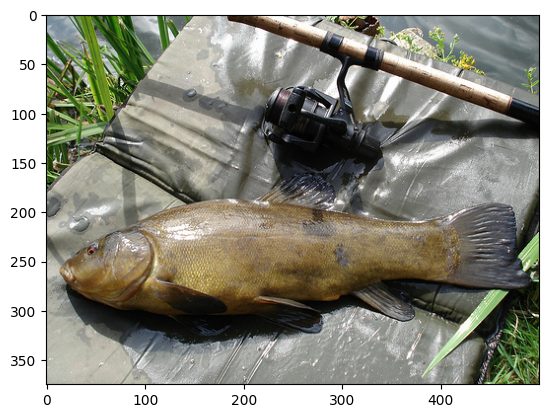

tench: 99.2%


In [6]:

# Load the pre-trained VGG16_BN model with default weights
model = models.vgg19_bn(pretrained=True)
weights = VGG19_BN_Weights.DEFAULT
model.eval()  # Set the model to evaluation mode

# Define preprocessing transforms for inference
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
image_path = '/kaggle/input/imagenet/val/n01440764/ILSVRC2012_val_00009111.JPEG'  # Change this to your image path
image = Image.open(image_path)
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

# Run inference
with torch.no_grad():
    output = model(input_batch)

# Map class indices to class labels
class_idx = {str(i): label for i, label in enumerate(labelDict)}


# Get predicted class index
# Step 4: Use the model and print the predicted category
prediction = model(input_batch).squeeze(0).softmax(0)
class_idx = prediction.argmax().item()
score = prediction[class_idx].item()
category_name = weights.meta["categories"][class_idx]
imshow(image)
print(f"{category_name}: {100 * score:.1f}%")


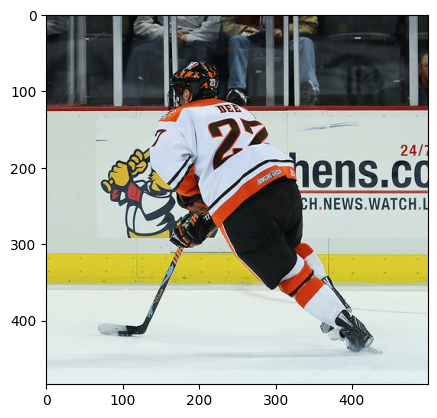

puck: 100.0%
puck, hockey puck
True


In [7]:
# select random image
imgPath = random.choice(test)
image1 = Image.open(imgPath)
#input_tensor = preprocess(image1)
#input_batch = input_tensor.unsqueeze(0)
# preprocess image
batch = preprocess(image1).unsqueeze(0)
# apply model
prediction = model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
imshow(image1)
print(f"{category_name}: {100 * score:.1f}%")
print(f"{labelDict[imgPath.split('/')[5]]}")
print(f"{category_name == labelDict[imgPath.split('/')[5]].split(', ')[0]}")

In [8]:
'''
# Directory containing all labeled subdirectories
val_dir = '/kaggle/input/imagenet/val/'
# List all labeled subdirectories
label_dirs = [os.path.join(val_dir, label) for label in os.listdir(val_dir)]
# Randomly select a labeled subdirectory
random_label_dir = random.choice(label_dirs)
# List all image files within the selected subdirectory
image_files = [os.path.join(random_label_dir, file) for file in os.listdir(random_label_dir) if file.endswith('.JPEG')]
# Randomly select an image file from the list
imgPath = random.choice(image_files)

image1 = Image.open(imgPath)
input_tensor = preprocess(image1)
input_batch = input_tensor.unsqueeze(0)
# preprocess image
batch = preprocess(image1).unsqueeze(0)
# apply model
prediction = model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
imshow(image1)
print(f"{category_name}: {100 * score:.1f}%")
print(imgPath)

print(f"{labelDict[imgPath.split('/')[-1]]}")
print(f"{category_name == labelDict[imgPath.split('/')[-1]].split(', ')[0]}")
'''


'\n# Directory containing all labeled subdirectories\nval_dir = \'/kaggle/input/imagenet/val/\'\n# List all labeled subdirectories\nlabel_dirs = [os.path.join(val_dir, label) for label in os.listdir(val_dir)]\n# Randomly select a labeled subdirectory\nrandom_label_dir = random.choice(label_dirs)\n# List all image files within the selected subdirectory\nimage_files = [os.path.join(random_label_dir, file) for file in os.listdir(random_label_dir) if file.endswith(\'.JPEG\')]\n# Randomly select an image file from the list\nimgPath = random.choice(image_files)\n\nimage1 = Image.open(imgPath)\ninput_tensor = preprocess(image1)\ninput_batch = input_tensor.unsqueeze(0)\n# preprocess image\nbatch = preprocess(image1).unsqueeze(0)\n# apply model\nprediction = model(batch).squeeze(0).softmax(0)\nclass_id = prediction.argmax().item()\nscore = prediction[class_id].item()\ncategory_name = weights.meta["categories"][class_id]\nimshow(image1)\nprint(f"{category_name}: {100 * score:.1f}%")\nprint(imgPa

In [9]:
def getModelAccuracy(model, dataset):
    numCorrect = 0.0
    numWrong = 0.0
    for imgPath in dataset:
        # read img
        img = Image.open(imgPath)
        # preprocess img
        batch = preprocess(img).unsqueeze(0)
        # get prediction
        prediction = model(batch).squeeze(0).softmax(0)
        # get class from prediction
        class_id = prediction.argmax().item()
        category_name = weights.meta["categories"][class_id]
        # compare predicted class (top 1) vs actual
        if category_name in labelDict[imgPath.split('/')[5]].split(', '):
            numCorrect += 1.0
        else:
            numWrong += 1.0
        # print iteration count every 50 iters
        if (numCorrect + numWrong) % 50 == 0:
            print(f'Iterations: {numCorrect + numWrong}')
    return numCorrect / (numWrong + numCorrect)

In [10]:
# comment out this line when trying different quant configs
acc = getModelAccuracy(model, random.choices(test, k=1000))
acc

Iterations: 50.0
Iterations: 100.0
Iterations: 150.0
Iterations: 200.0
Iterations: 250.0
Iterations: 300.0
Iterations: 350.0
Iterations: 400.0
Iterations: 450.0
Iterations: 500.0
Iterations: 550.0
Iterations: 600.0
Iterations: 650.0
Iterations: 700.0
Iterations: 750.0
Iterations: 800.0
Iterations: 850.0
Iterations: 900.0
Iterations: 950.0
Iterations: 1000.0


0.736

In [11]:
# default q_config
from torch.ao.quantization.quantizer.xnnpack_quantizer import (
  XNNPACKQuantizer,
  get_symmetric_quantization_config,
)
from torch.ao.quantization import get_default_qconfig
# custom q_config
from torch.ao.quantization.observer import (
    HistogramObserver,
    MinMaxObserver,
)

from torch.ao.quantization.quantizer.xnnpack_quantizer_utils import (
    QuantizationConfig,
)

from torch.ao.quantization.quantizer import QuantizationSpec, Quantizer
from torch.ao.quantization.qconfig import _ObserverOrFakeQuantizeConstructor

In [12]:
# activation config

# for 8bit int range -128 to 127 and dtype=torch.int8
# for 7bit int range -64 to 63 and dtype=torch.int8
# for 6bit int range -32 to 31 and dtype=torch.int8
# for 5bit int range -16 to 15 and dtype=torch.int8
# for 4bit int range -8 to 7 and dtype=torch.int8
quant_dtype = torch.int8
quant_min = -8
quant_max = 7

In [13]:

act_qmin = quant_min
act_qmax = quant_max
extra_args: dict[str, any] = {"eps": 2**-12}

act_quantization_spec = QuantizationSpec(
    dtype=quant_dtype,
    quant_min=act_qmin,
    quant_max=act_qmax,
    qscheme=torch.per_tensor_affine,
    is_dynamic=False,
    observer_or_fake_quant_ctr=HistogramObserver.with_args(
        **extra_args,
    ),
)

act_quantization_spec

QuantizationSpec(dtype=torch.int8, observer_or_fake_quant_ctr=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, eps=0.000244140625){}, quant_min=-8, quant_max=7, qscheme=torch.per_tensor_affine, ch_axis=None, is_dynamic=False)

In [14]:
# weight config    
weight_observer_or_fake_quant_ctr: _ObserverOrFakeQuantizeConstructor = (
    MinMaxObserver
)
# activation config
# for 8bit int range -128 to 127 and dtype=torch.int8
# for 6bit int range -32 to 31 and dtype=torch.int8
# for 4bit int range -8 to 7 and dtype=torch.int8
weight_qscheme = torch.per_tensor_symmetric
weight_qmin = quant_min + 1 # defaults to -127 (not -128) in pytorch github, likely to center around zero?
weight_qmax = quant_max 
weight_quantization_spec = QuantizationSpec(
    dtype=quant_dtype,
    quant_min=weight_qmin,
    quant_max=weight_qmax,
    qscheme=weight_qscheme,
    ch_axis=0,
    is_dynamic=False,
    observer_or_fake_quant_ctr=weight_observer_or_fake_quant_ctr.with_args(
        **extra_args
    ),
)

weight_quantization_spec

QuantizationSpec(dtype=torch.int8, observer_or_fake_quant_ctr=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, eps=0.000244140625){}, quant_min=-7, quant_max=7, qscheme=torch.per_tensor_symmetric, ch_axis=0, is_dynamic=False)

In [15]:
quantization_config = QuantizationConfig(
            act_quantization_spec,
            act_quantization_spec,
            weight_quantization_spec,
            None,
            False,
        )

In [16]:
from torch.ao.quantization.quantizer.xnnpack_quantizer import (
  XNNPACKQuantizer,
  get_symmetric_quantization_config,
)
# export model
from torch._export import capture_pre_autograd_graph

example_inputs = (torch.rand(2, 3, 224, 224),)
exported_model = capture_pre_autograd_graph(model, example_inputs)
#q_config = get_symmetric_quantization_config()
quantizer = XNNPACKQuantizer()
quantizer.set_global(quantization_config)
prepared_model = prepare_pt2e(exported_model, quantizer)
print(prepared_model.graph)

graph():
    %arg0 : [num_users=1] = placeholder[target=arg0]
    %activation_post_process_0 : [num_users=1] = call_module[target=activation_post_process_0](args = (%arg0,), kwargs = {})
    %_param_constant0 : [num_users=1] = get_attr[target=_param_constant0]
    %activation_post_process_1 : [num_users=1] = call_module[target=activation_post_process_1](args = (%_param_constant0,), kwargs = {})
    %_param_constant1 : [num_users=1] = get_attr[target=_param_constant1]
    %conv2d_default : [num_users=1] = call_function[target=torch.ops.aten.conv2d.default](args = (%activation_post_process_0, %activation_post_process_1, %_param_constant1, [1, 1], [1, 1]), kwargs = {})
    %relu__default : [num_users=1] = call_function[target=torch.ops.aten.relu_.default](args = (%conv2d_default,), kwargs = {})
    %activation_post_process_2 : [num_users=1] = call_module[target=activation_post_process_2](args = (%relu__default,), kwargs = {})
    %_param_constant4 : [num_users=1] = get_attr[target=_param_

In [17]:
# define calibration function
def calibrate(model, dataset):
    #model.eval()
    numIter = 0
    with torch.no_grad():
        for imgPath in dataset:
                img = Image.open(imgPath)
                batch = preprocess(img).unsqueeze(0)
                model(batch).squeeze(0).softmax(0)
                numIter += 1
                if numIter % 50 == 0:
                    print(f'Iterations: {numIter}')
# run calibration
calibrate(prepared_model, random.choices(train, k=1000))  # run calibration on sample data

Iterations: 50
Iterations: 100
Iterations: 150
Iterations: 200
Iterations: 250
Iterations: 300
Iterations: 350
Iterations: 400
Iterations: 450
Iterations: 500
Iterations: 550
Iterations: 600
Iterations: 650
Iterations: 700
Iterations: 750
Iterations: 800
Iterations: 850
Iterations: 900
Iterations: 950
Iterations: 1000


In [18]:
quantized_model = convert_pt2e(prepared_model)
print(quantized_model)

GraphModule()



def forward(self, x):
    arg0, = fx_pytree.tree_flatten_spec(([x], {}), self._in_spec)
    quantize_per_tensor_default = torch.ops.quantized_decomposed.quantize_per_tensor.default(arg0, 0.31703871488571167, -1, -8, 7, torch.int8);  arg0 = None
    dequantize_per_tensor_default = torch.ops.quantized_decomposed.dequantize_per_tensor.default(quantize_per_tensor_default, 0.31703871488571167, -1, -8, 7, torch.int8);  quantize_per_tensor_default = None
    _param_constant0 = self._param_constant0
    quantize_per_tensor_default_1 = torch.ops.quantized_decomposed.quantize_per_tensor.default(_param_constant0, 0.30676335096359253, 0, -7, 7, torch.int8);  _param_constant0 = None
    dequantize_per_tensor_default_1 = torch.ops.quantized_decomposed.dequantize_per_tensor.default(quantize_per_tensor_default_1, 0.30676335096359253, 0, -7, 7, torch.int8);  quantize_per_tensor_default_1 = None
    _param_constant1 = self._param_constant1
    conv2d_default = torch.ops.aten.conv2d.defa

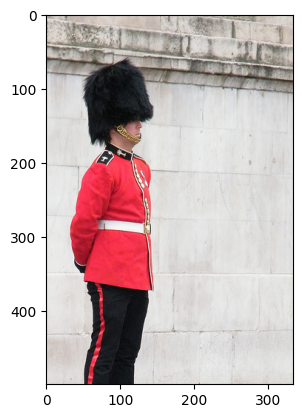

cannon: 7.3%
bearskin
False


In [19]:
# select random image
imgPath = random.choice(test)
img = Image.open(imgPath)
# preprocess image
batch = preprocess(img).unsqueeze(0)
# apply model
prediction = quantized_model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
imshow(img)
print(f"{category_name}: {100 * score:.1f}%")
print(f"{labelDict[imgPath.split('/')[5]].split(', ')[0]}")
print(f"{category_name == labelDict[imgPath.split('/')[5]].split(', ')[0]}")

In [20]:
acc = getModelAccuracy(quantized_model, random.choices(test, k=500))
acc

Iterations: 50.0
Iterations: 100.0
Iterations: 150.0
Iterations: 200.0
Iterations: 250.0
Iterations: 300.0
Iterations: 350.0
Iterations: 400.0
Iterations: 450.0
Iterations: 500.0


0.0

In [21]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (KB):', os.path.getsize("temp.p")/1e3)
    os.remove('temp.p')

In [22]:
print_size_of_model(model)

Size (KB): 574787.16


In [23]:
print_size_of_model(quantized_model)

Size (KB): 574677.926
